In [58]:
import pandas as pd
import numpy as np
import time
import os
import requests
import json
import urllib.request
import re
import pickle
import networkx as nx
import string

In [69]:
app_id = '24ac8855'
app_key = 'baa032bb2944756dcf361a18ae7e3ab9'

actual_dictionary = {}

alphabet = set(list(string.ascii_lowercase) + list(string.ascii_uppercase))

def find_defs(diction):
    """
    This function executes when we reach a list containing dictionary data strucutres that may contain several different
    definitions for a given word. It runs through this list, for each list finding keys in the dictionary data
    structure containing the string "definitions" or "short_definitions" and appending the corresponding value 
    (a string) of this key to a master string, which we call stringy. At the end of this function, we use the 
    built-in function set() on the list given to us by the .split() method. The reasons for a set are:
    1) checking membership in sets is efficient in python
    2) sets do not contain duplicate elements, so we are using less space.
    """
    stringy = ''
    for i in diction:
        for k, v in i.items():
            if k == 'definitions' or k == 'short_definitions' or k == 'crossReferenceMarkers':
                stringy += v[0] + ' '
    stringy = stringy.split(' ')
    for i in stringy:
        if i[0] not in alphabet:
            stringy[i] = i[1:]
        if i[-1] not in alphabet:
            stringy[i] = i[:-1]
    return set(stringy)

def find_definition(word):
    """
    This function takes in a word as input and creates an entry in our dataset consisting of a word-definition pair.
    """
    
    url = 'https://od-api.oxforddictionaries.com:443/api/v1/entries/en/' + word.lower()
    # there may be times while looking up words that the dictionary does not contain a word for whatever reason.
    # this chunk of code catches this error.
    try:
        r = requests.get(url, headers = {'app_id': app_id, 'app_key': app_key})
        dicty = r.json()
        # # Need to consider words like "won" that have atypical structure...........       
        # this process is ugly, but it works. 
        # The structure of the data returned from the API call is a bit awkward.
        first_layer = dicty['results']
        second_layer = first_layer[0]
        third_layer = second_layer['lexicalEntries']
        # third layer contains multiple definitions or "senses" of the word
        fourth_layer = third_layer[0]
        fifth_layer = fourth_layer['entries']
        sixth_layer = fifth_layer[0]
        seventh_layer = sixth_layer['senses']
        if find_defs(seventh_layer) != {''}:
            actual_dictionary[word.lower()] = find_defs(seventh_layer)
        else:
            pass
    except json.JSONDecodeError:
        print("something fucked up with " + word)
        pass
    
def find_contents(diction):
    try:
        for k, v in diction.items():
            print(k, '\n', v, '\n\n')
    except AttributeError:
        for i in diction:
            print(i, '\n\n')

In [3]:
# Defining functions using "Pickle" library that allow us to save python objects as .pkl files that, when loaded again,
# act just like the objects we saved them as without needing to transform them.

# This allows us to save a dictionary instead of needing to reconsruct a dictionary for each info-theoretic calculation.

def save_obj(obj, name):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
word_csv = pd.read_csv('Dictionaries/Cambridge_gk-scch.csv', sep=';')
word_list = list(set(word_csv['WORD'].tolist()))

In [ ]:
for word in word_list:
    try:
        find_definition(word)
    except KeyError:
        pass
    # add delay so we don't reach API call/min ceiling.
    time.sleep(.2)

save_obj(actual_dictionary, 'dictionary')

find_contents(actual_dictionary)

Cap reached for has
Cap reached for latest
Cap reached for had
Cap reached for willful
Cap reached for prepared
Cap reached for taken
Cap reached for bacteria
Cap reached for forwards
Cap reached for extrasensory
Cap reached for postmortem
Cap reached for bends
Cap reached for machinations
Cap reached for bowels


In [5]:
dicty = load_obj('dictionary')

In [56]:
find_contents(dicty)

custom 
 {'', 'to', 'customers', 'particular', 'a', 'practice', 'time', 'by', 'place,', 'something', 'that', 'way', 'society,', 'or', 'behaving', 'widely', 'of', 'dealings', 'doing', 'business', 'and', 'specific', 'with', 'is', 'accepted', 'regular', 'traditional', 'shop'} 


alternative 
 {'', 'to', 'challenge', '(of', 'unconventional', 'norms', 'more', 'relating', 'one', 'that', 'or', 'choice', 'depart', 'activities', 'another', 'from', 'things)', 'traditional', 'available', 'as', 'possibility'} 


flesh 
 {'', 'fat', 'found', 'between', 'a', 'an', 'soft', 'substance', 'that', 'or', 'human', 'muscle', 'body', 'of', 'skin', 'bones', 'animal', 'consisting', 'and', 'tissue', 'is', 'in', 'the'} 


fault 
 {'', 'extended', 'character', 'particular', 'a', 'by', 'an', 'formation,', 'strata', 'feature,', 'or', 'feature', 'displacement', 'for', 'either', 'of', 'accident', 'marked', 'side', 'on', 'responsibility', 'work', 'unattractive', 'relative', 'misfortune', 'piece', 'especially', 'and', 

 {'', '(something)', 'stitches', 'with', 'join,', 'or', 'needle', 'thread', 'a', 'machine', 'fasten,', 'by', 'and', 'something', 'sewing', 'repair', 'making'} 


lock 
 {'', 'fastened,', 'to', 'closed', 'motion.', 'exploding', 'used', 'scrum.', 'change', 'lowering', 'row', 'can', 'a', 'by', 'level,', 'something', 'gates', 'that', 'gun.', 'container', 'scrum', 'door,', 'which', 'sluices', 'keeping', 'turning', 'section', 'or', 'player', 'opened', 'river', 'for', 'direction', 'its', 'of', 'be', 'person', 'end', 'certainty', 'charge', 'key', 'water', 'raising', 'wheels', 'and', 'mechanism', 'canal', 'boats', 'gated', 'gun', 'short', 'second', 'is', 'with', 'window,', 'certain', 'at', 'lid,', 'front', 'fastened', 'operated', 'typically', 'in', 'succeed;', 'each', 'vehicle', 'thing', 'the'} 


educate 
 {'', 'to', 'university', 'instruction', 'or', 'at', 'intellectual,', 'a', 'typically', 'give', 'school', 'moral,', '(someone),', 'and', 'social', 'someone'} 


sour 
 {'', '(of', 'usually', 

Dictionaries can be represented as directed graphs D = (V, A) (digraphs). The vertices
(i.e. the members of v) are words and the arcs connect defining words to defined words,
that is, there is an arc from word u to word v if u is a word in the definition of v. More-
over, in a complete dictionary, every word is defined by at least one word, so we assume
that there is no word without an incoming arc. A path is a sequence (v 1 , v 2, ..., v k ) of ver-
tices such that (v i , v i+1 ) is an arc for i = 1, 2, ..., k-1. A circuit is a path starting and end-
ing at the same vertex. A graph is called acyclic if it does not contain any circuits.

Let U x V be any subset of words and let u be some given word. We are interested
in computing all words that can be learned through definitions composed only of words
in U. This can be stated recursively as follows: We say that u is definable from U if
all predecessors of u either belong to U or are definable from U. The set of words that
can be defined from U is denoted by Def(U). In particular, if Def (U)∪U = V, then U
is called a grounding set of D. Intuitively, a set U is a grounding set if, provided we
already know the meaning of each word in U, we can learn the meaning of all the
remaining words just by looking up the definitions of the unknown words (in the right
order).

As a first step, we observed that in all dictionaries analyzed so far there exist many
words that are never used in any definition. These words can be removed without chang-
ing the MinSets. This reduction can be done iteratively until no further word can be
removed without leaving any word undefinable from the rest. The resulting subgraph is
what we called the dictionary’s (grounding) Kernel

Next, since we are dealing with directed graphs, we can subdivide the words according
to their strongly connected components (SCCs). Two words u and v are strongly connected
if there exists a path from u to v as well as a path from v to u. 

In [37]:
Dictionary = nx.DiGraph()
Dictionary.add_nodes_from(dicty.keys())

['custom',
 'alternative',
 'flesh',
 'fault',
 'single',
 'system',
 'grass',
 'intestine',
 'variety',
 'mathematics',
 'roman',
 'beaver',
 'lack',
 'own',
 'fertile',
 'branch',
 'headlight',
 'obvious',
 'thick',
 'shoe',
 'candle',
 'belief',
 'dead',
 'brother',
 'temper',
 'colour',
 'cloud',
 'hope',
 'proton',
 'pet',
 'beat',
 'melt',
 'irregular',
 'directly',
 'influence',
 'infect',
 'process',
 'surgery',
 'row',
 'window',
 'free',
 'relate',
 'talk',
 'china',
 'pan',
 'shock',
 'arm',
 'drop',
 'video',
 'mend',
 'mallet',
 'health',
 'order',
 'stem',
 'love',
 'chest',
 'sex',
 'chocolate',
 'excite',
 'store',
 'keyboard',
 'chuck',
 'tobacco',
 'gather',
 'mum',
 'hit',
 'knowledge',
 'anger',
 'desire',
 'missile',
 'wet',
 'save',
 'random',
 'tax',
 'surround',
 'allow',
 'large',
 'dirt',
 'watch',
 'agent',
 'country',
 'taste',
 'programme',
 'honour',
 'draw',
 'force',
 'shelves',
 'farm',
 'circle',
 'bone',
 'rainy',
 'component',
 'pasta',
 'subway',
 '

In [43]:
len(Dictionary)

1845

In [31]:
list(Dictionary.nodes)

['custom',
 'alternative',
 'flesh',
 'fault',
 'single',
 'system',
 'grass',
 'intestine',
 'variety',
 'mathematics',
 'roman',
 'beaver',
 'lack',
 'own',
 'fertile',
 'branch',
 'headlight',
 'obvious',
 'thick',
 'shoe',
 'candle',
 'belief',
 'dead',
 'brother',
 'temper',
 'colour',
 'cloud',
 'hope',
 'proton',
 'pet',
 'beat',
 'melt',
 'irregular',
 'directly',
 'influence',
 'infect',
 'process',
 'surgery',
 'row',
 'window',
 'free',
 'relate',
 'talk',
 'china',
 'pan',
 'shock',
 'arm',
 'drop',
 'video',
 'mend',
 'mallet',
 'health',
 'order',
 'stem',
 'love',
 'chest',
 'sex',
 'chocolate',
 'excite',
 'store',
 'keyboard',
 'chuck',
 'tobacco',
 'gather',
 'mum',
 'hit',
 'knowledge',
 'anger',
 'desire',
 'missile',
 'wet',
 'save',
 'random',
 'tax',
 'surround',
 'allow',
 'large',
 'dirt',
 'watch',
 'agent',
 'country',
 'taste',
 'programme',
 'honour',
 'draw',
 'force',
 'shelves',
 'farm',
 'circle',
 'bone',
 'rainy',
 'component',
 'pasta',
 'subway',
 '

In [74]:
def createEdgesFromDefinitions(graph, dictionary):
    for word_1, definition_1 in dictionary.items():
        for word_2, definition_2 in dictionary.items():
            if word_2 in definition_1:
                graph.add_edge(word_2, word_1)

createEdgesFromDefinitions(Dictionary, dicty)              
            

In [78]:
list(Dictionary.edges)

[('custom', 'particular'),
 ('custom', 'regular'),
 ('custom', 'business'),
 ('custom', 'something'),
 ('custom', 'is'),
 ('custom', 'time'),
 ('custom', 'shop'),
 ('custom', 'way'),
 ('alternative', 'as'),
 ('alternative', 'available'),
 ('alternative', 'choice'),
 ('alternative', 'more'),
 ('alternative', 'depart'),
 ('alternative', 'one'),
 ('alternative', 'chair'),
 ('alternative', 'instead'),
 ('alternative', 'have'),
 ('alternative', 'way'),
 ('flesh', 'tissue'),
 ('flesh', 'found'),
 ('flesh', 'fat'),
 ('flesh', 'is'),
 ('flesh', 'body'),
 ('flesh', 'animal'),
 ('flesh', 'skin'),
 ('flesh', 'human'),
 ('flesh', 'substance'),
 ('flesh', 'soft'),
 ('flesh', 'muscle'),
 ('flesh', 'thin'),
 ('flesh', 'fig'),
 ('flesh', 'meat'),
 ('fault', 'work'),
 ('fault', 'side'),
 ('fault', 'break'),
 ('fault', 'particular'),
 ('fault', 'rock'),
 ('fault', 'unattractive'),
 ('fault', 'either'),
 ('fault', 'plane'),
 ('fault', 'accident'),
 ('fault', 'especially'),
 ('fault', 'feature'),
 ('fault

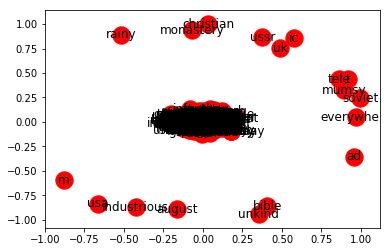

In [72]:
import matplotlib as plt

nx.draw_networkx(Dictionary)